# MOOC Analysis

This notebook conducts analysis on the trends of online learning through MOOC platforms with respect to developer trends at different skill levels

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 05/30/2025   | Martin | Create  | Notebook for analysis of MOOC data. Started visual summary of dataframe | 
| 06/02/2025   | Martin | Update  | Completed summary plots. To add explanations. Moving on to analysis| 
| 06/05/2025   | Martin | Update  | Completed assignment of skill level of responses in Stack Overflow dataset | 

# Content

* [Introduction](#introduction)
* [Data](#data)
* [Summary Breakdown](#summary-breakdown)
* [Identify Skill Level in Developers](#identify-skill-level-in-developers)
* [Q1: Common Skills](#q1-common-skills)
* [Q2: Duration?](#q2-duration)

# Introduction

The journey of a develop and data scientist is a never-ending thirst for new knowledge and upskilling. As new technologies are constantly being created, the onus is on us to continually update ourselves with new and relevant skills that are used within the industry. The rise of MOOC platforms has made picking up these skills much easier compared to the past. Courses cover a wide variety of topics from general overviews of a tool, to projects that aim to impart very specific skills.

The consensus in the community is that there are some fundamentals that should be developed before moving on to more advanced concepts. As such, the focus of this analysis is to identify the different trends related to the skills required at each level. We also compare this to the general programming community to see if the courses and projects offered by MOOC platforms are congruent with the skills in-demand by existing developers and data scientists

# Data

We are using the `combined_mooc.csv` and the (INSERT STACKOVERFLOW DATASET) as our primary dataframes to conduct this analysis

<u>Key points on MOOC dataset</u>
* 3 levels of skill encoded (Beginner, Intermediate, Advanced)

In [1]:
import ast
import nltk

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [2]:
try:
  print(stopwords.words('english'))
except Exception:
  nltk.download('stopwords')
  nltk.download('punkt_tab')
  print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [3]:
# Load MOOC data - some values are stored as lists and need to be converted back
df_mooc = pd.read_csv('combined_mooc.csv', low_memory=False)

cols_to_convert = ['skills', 'reviews', 'subject', 'reviews_comments', 'reviews_stars']
for col in cols_to_convert:
  df_mooc[col] = df_mooc[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)

In [4]:
df_mooc.head()

,type,course_name,organization,rating,description,skills,level,duration,reviews,enrollments,subject,provider,language,reviews_comments,reviews_stars,reviews_avg_stars,num_reviews,premium
0,course,AWS Lambda إنشاء صورة مصغرة بإستخدام السيرفرل...,Coursera Project Network,NaN,هذا المشروع التفاعلي -إنشاء صورة مصغرة بإستخدا...,"[AWS Identity And Access Management (IAM), Clo...",Intermediate,2.0,NaN,NaN,NaN,coursera,ar,NaN,NaN,NaN,NaN,NaN
1,course,Assisting Public Sector Decision Makers With ...,University of Michigan,4.8,Develop data analysis skills that support publ...,"[Simulations, Statistical Analysis, Predictive...",Intermediate,16.0,[{'comment': 'This course was very good at get...,NaN,NaN,coursera,en,[wonderful],[5],5.0,1.0,NaN
2,course,Advanced Strategies for Sustainable Business,University of Colorado Boulder,NaN,This course focuses on integrating sustainabil...,"[Circular Economy, Sustainable Business, Stake...",Beginner,6.0,NaN,NaN,NaN,coursera,en,NaN,NaN,NaN,NaN,NaN
3,course,Applying Machine Learning to Your Data with G...,Google Cloud,NaN,"Dans ce cours, nous définirons ce qu'est le ma...",NaN,Beginner,10.0,NaN,NaN,NaN,coursera,fr,NaN,NaN,NaN,NaN,NaN
4,project,Automate Blog Advertisements with Zapier,Coursera Project Network,NaN,Zapier is the industry leader in task automati...,"[Advertising, Social Media, Blogging, Marketing]",Intermediate,2.0,"[{'comment': 'wonderful', 'stars': 5}]",NaN,NaN,coursera,en,"[Very good way of teaching., Good, Good]","[5, 5, 5]",5.0,3.0,NaN


# Summary Breakdown

First we create a breakdown for some columns and derive some basic insights about the MOOC dataset

Summary bar plots - description to be added

In [5]:
# Data processing to generate plots
count_type = df_mooc['type'].value_counts()
count_type = pd.DataFrame(count_type).reset_index()

count_organization = df_mooc['organization'].value_counts()
count_organization = pd.DataFrame(count_organization).reset_index()
top_10_organization = count_organization.iloc[:10].sort_values('count')

count_level = df_mooc['level'].value_counts()
count_level = count_level.reindex(index=['Mixed', 'Advanced', 'Intermediate', 'Beginner'])
count_level = pd.DataFrame(count_level).reset_index()

count_provider = df_mooc['provider'].value_counts().sort_values()
count_provider = pd.DataFrame(count_provider).reset_index()

count_languages = df_mooc['language'].value_counts().sort_values()
count_languages = pd.DataFrame(count_languages).reset_index()
top_10_languages = count_languages.iloc[-10:]

count_premium = df_mooc['premium'].value_counts().sort_values()
count_premium = pd.DataFrame(count_premium).reset_index()
count_premium['premium'] = ['Free', 'Paid']

all_skills = np.concatenate(df_mooc['skills'].dropna().to_numpy())
all_skills = np.unique(all_skills, return_counts=True)
all_skills = {
  'skills': all_skills[0],
  'count': all_skills[1]
}
all_skills = pd.DataFrame(all_skills).sort_values('count')
top_20_skills = all_skills.iloc[-20:]

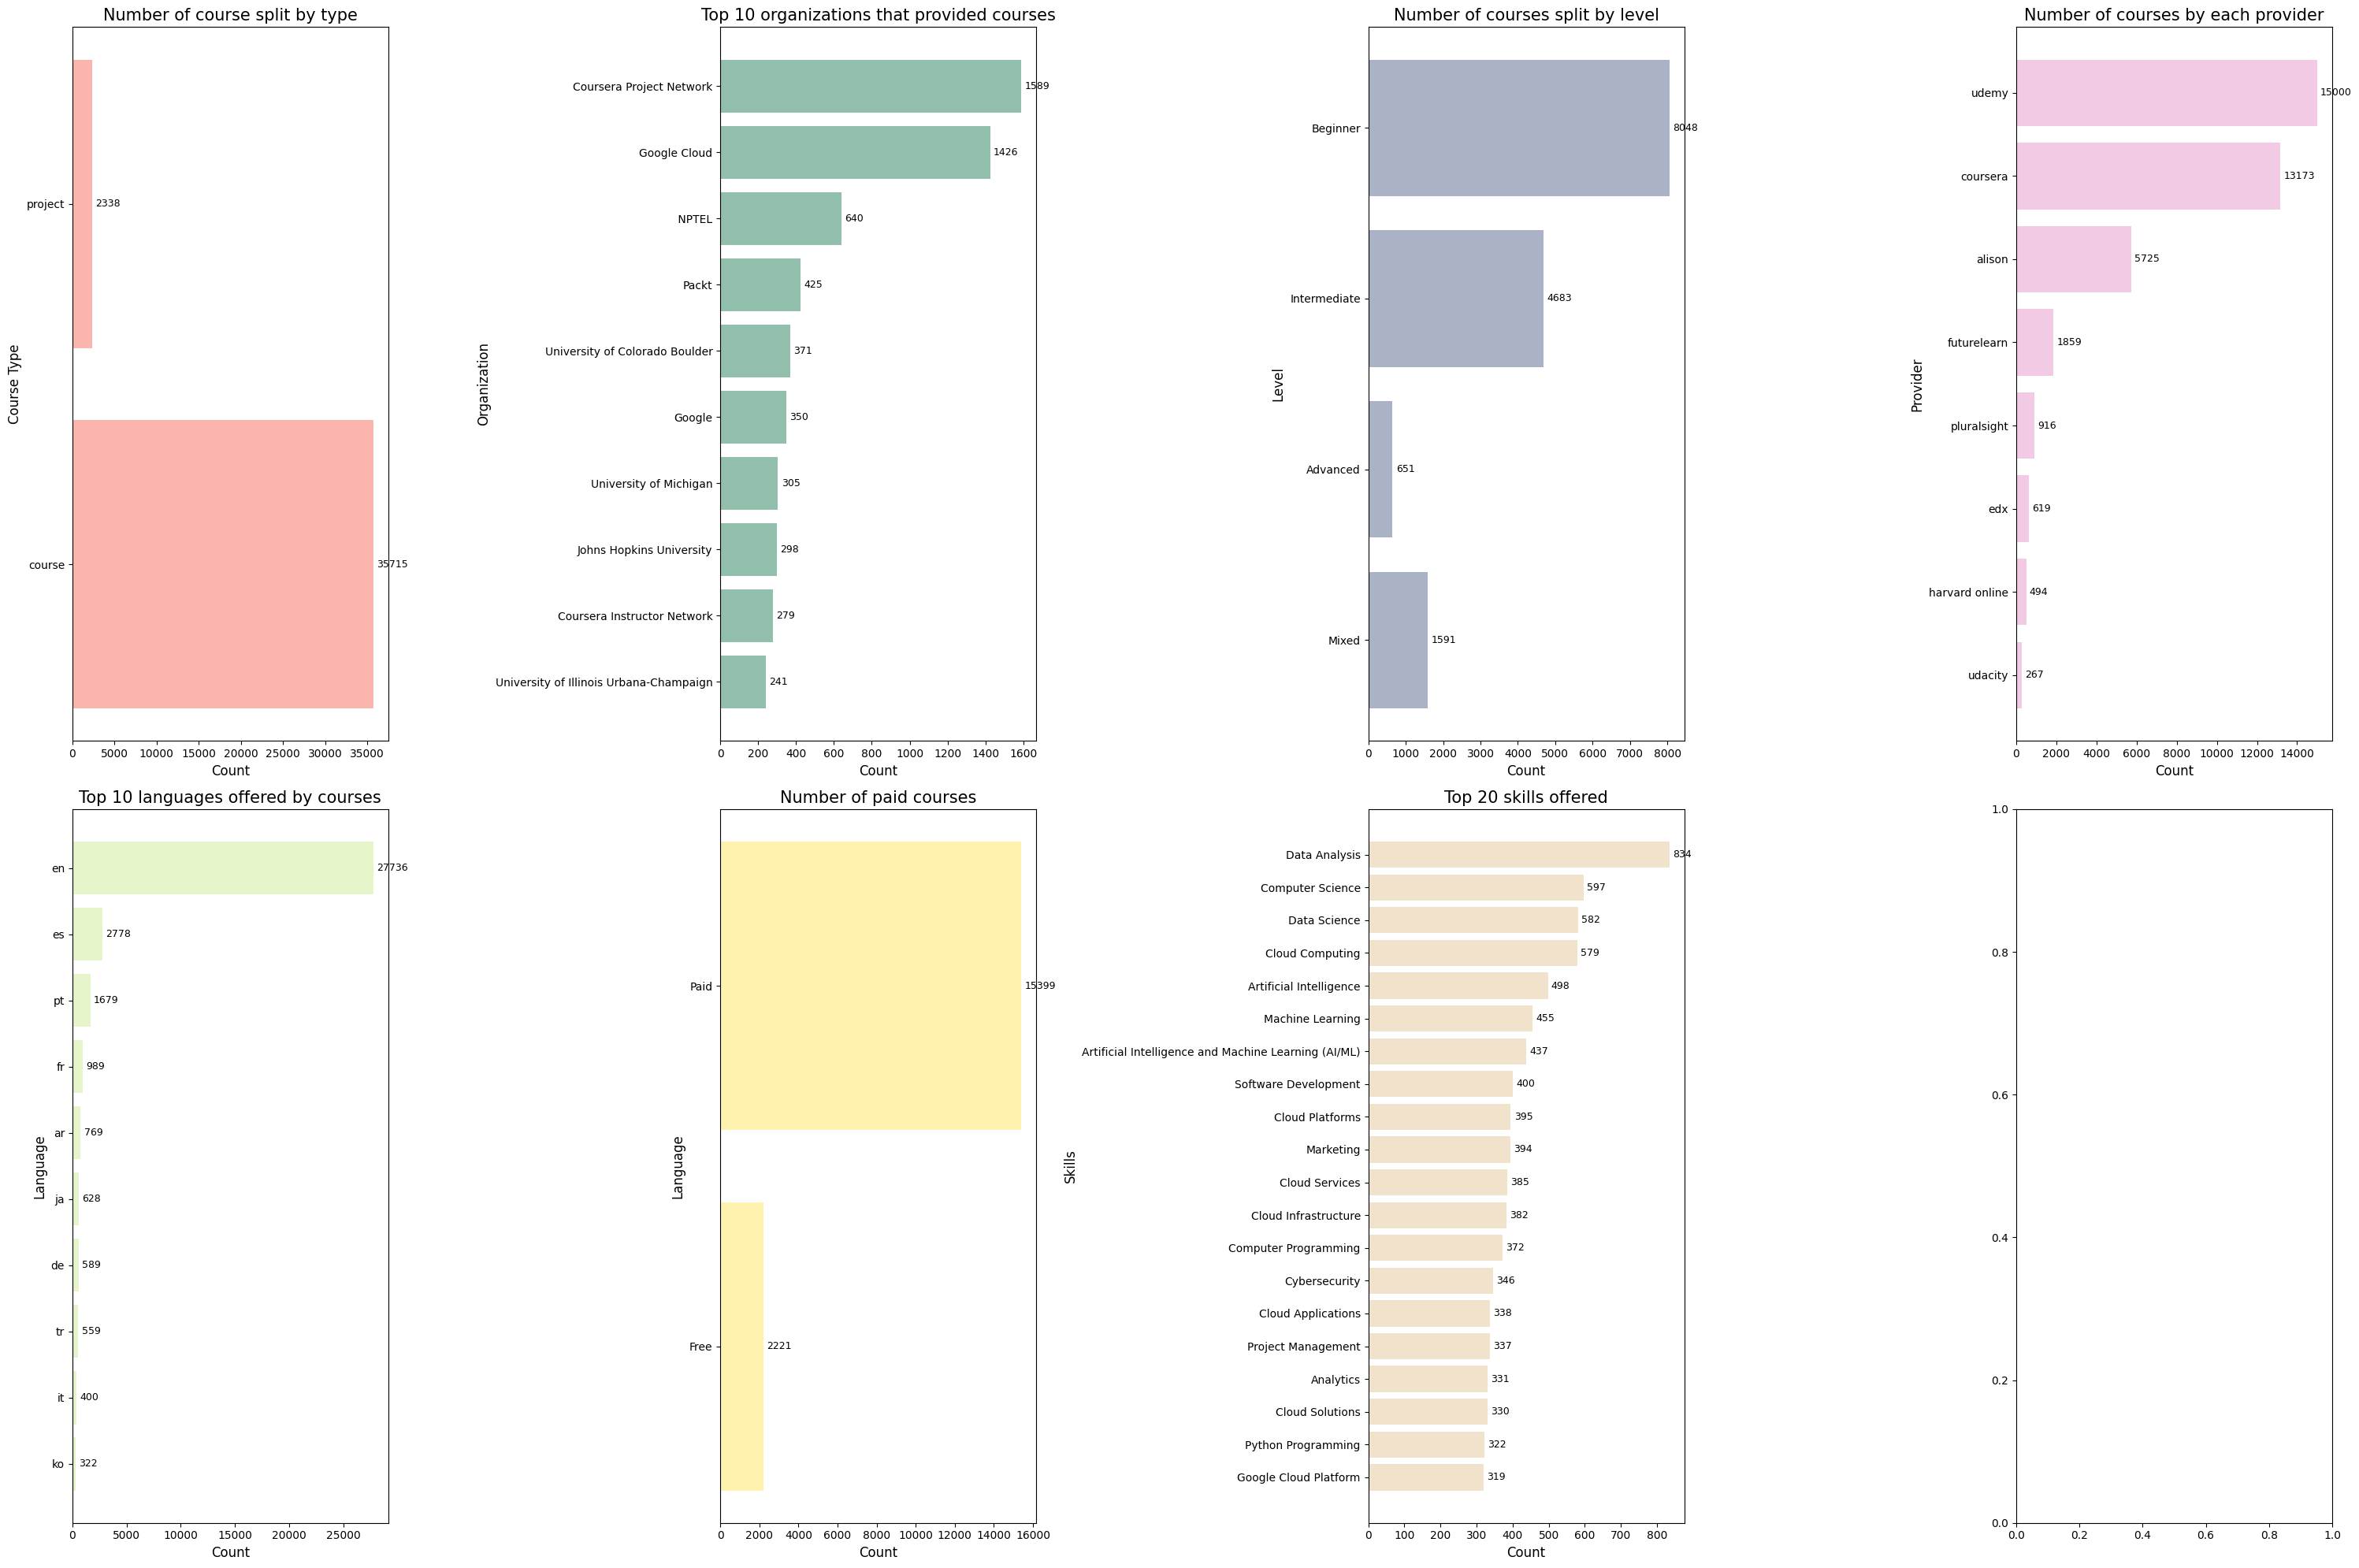

In [6]:
# Define global variables
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.Pastel1.colors)
FS = 12

fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(20)
fig.set_figwidth(30)

# 1. Countplot of type column
bars = ax[0, 0].barh(count_type['type'], count_type['count'])
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 0].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 0].set_title("Number of course split by type", fontsize=FS+3)
ax[0, 0].set_ylabel("Course Type", fontsize=FS)
ax[0, 0].set_xlabel("Count", fontsize=FS)

# 2. Countplot of organisation column
bars = ax[0, 1].barh(top_10_organization['organization'], top_10_organization['count'], color="#92bfab")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 1].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 1].set_title("Top 10 organizations that provided courses", fontsize=FS+3)
ax[0, 1].set_ylabel("Organization", fontsize=FS)
ax[0, 1].set_xlabel("Count", fontsize=FS)

# 3. Countplot of level column
bars = ax[0, 2].barh(count_level['level'], count_level['count'], color="#a9b3c5")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 2].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 2].set_title("Number of courses split by level", fontsize=FS+3)
ax[0, 2].set_ylabel("Level", fontsize=FS)
ax[0, 2].set_xlabel("Count", fontsize=FS)

# 4. Countplot of provider column
bars = ax[0, 3].barh(count_provider['provider'], count_provider['count'], color="#f3cae4")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 3].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 3].set_title("Number of courses by each provider", fontsize=FS+3)
ax[0, 3].set_ylabel("Provider", fontsize=FS)
ax[0, 3].set_xlabel("Count", fontsize=FS)

# 5. Countplot of languages column
bars = ax[1, 0].barh(top_10_languages['language'], top_10_languages['count'], color="#e5f5c9")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 0].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 0].set_title("Top 10 languages offered by courses", fontsize=FS+3)
ax[1, 0].set_ylabel("Language", fontsize=FS)
ax[1, 0].set_xlabel("Count", fontsize=FS)

# 6. Countplot of premium column
bars = ax[1, 1].barh(count_premium['premium'], count_premium['count'], color="#fff2ae")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 1].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 1].set_title("Number of paid courses", fontsize=FS+3)
ax[1, 1].set_ylabel("Language", fontsize=FS)
ax[1, 1].set_xlabel("Count", fontsize=FS)

# 7. Top 20 skills
bars = ax[1, 2].barh(top_20_skills['skills'], top_20_skills['count'], color="#f1e2cc")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[1, 2].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[1, 2].set_title("Top 20 skills offered", fontsize=FS+3)
ax[1, 2].set_ylabel("Skills", fontsize=FS)
ax[1, 2].set_xlabel("Count", fontsize=FS)

fig.tight_layout()

Histogram plots - description to be added

In [7]:
def custom_hist_kde_plot(
  data: pd.Series,
  box_color: str,
  line_color: str,
  title: str,
  axes: list
):
  # Define the base histogram + kde plot
  plot = sns.histplot(data, kde=True, bins=40, color=box_color, line_kws={'color': 'red'}, ax=axes)
  plot.lines[0].set_color(line_color)
  plt.setp(plot.patches, linewidth=0.5)

  # Add the mean line
  mean = np.mean(data)
  plot.axvline(mean, color='#33a02c')
  scaled_x_pos = mean - 0.01 * mean
  scaled_y_pos = plot.get_ylim()[1] - 0.02*plot.get_ylim()[1]
  plot.text(scaled_x_pos, scaled_y_pos, f"Mean:\n{round(mean, 2)}", color='#33a02c', ha='right', va='top')

  # Add the median line
  median = np.median(data)
  plot.axvline(median, color='#1e78b4')
  scaled_x_pos = median - 0.01 * median
  scaled_y_pos = plot.get_ylim()[1] - 0.15*plot.get_ylim()[1]
  plot.text(scaled_x_pos, scaled_y_pos, f"Median:\n{round(median, 2)}", color='#1e78b4', ha='right', va='top')

  # Title
  plot.set_title(title)

  return plot

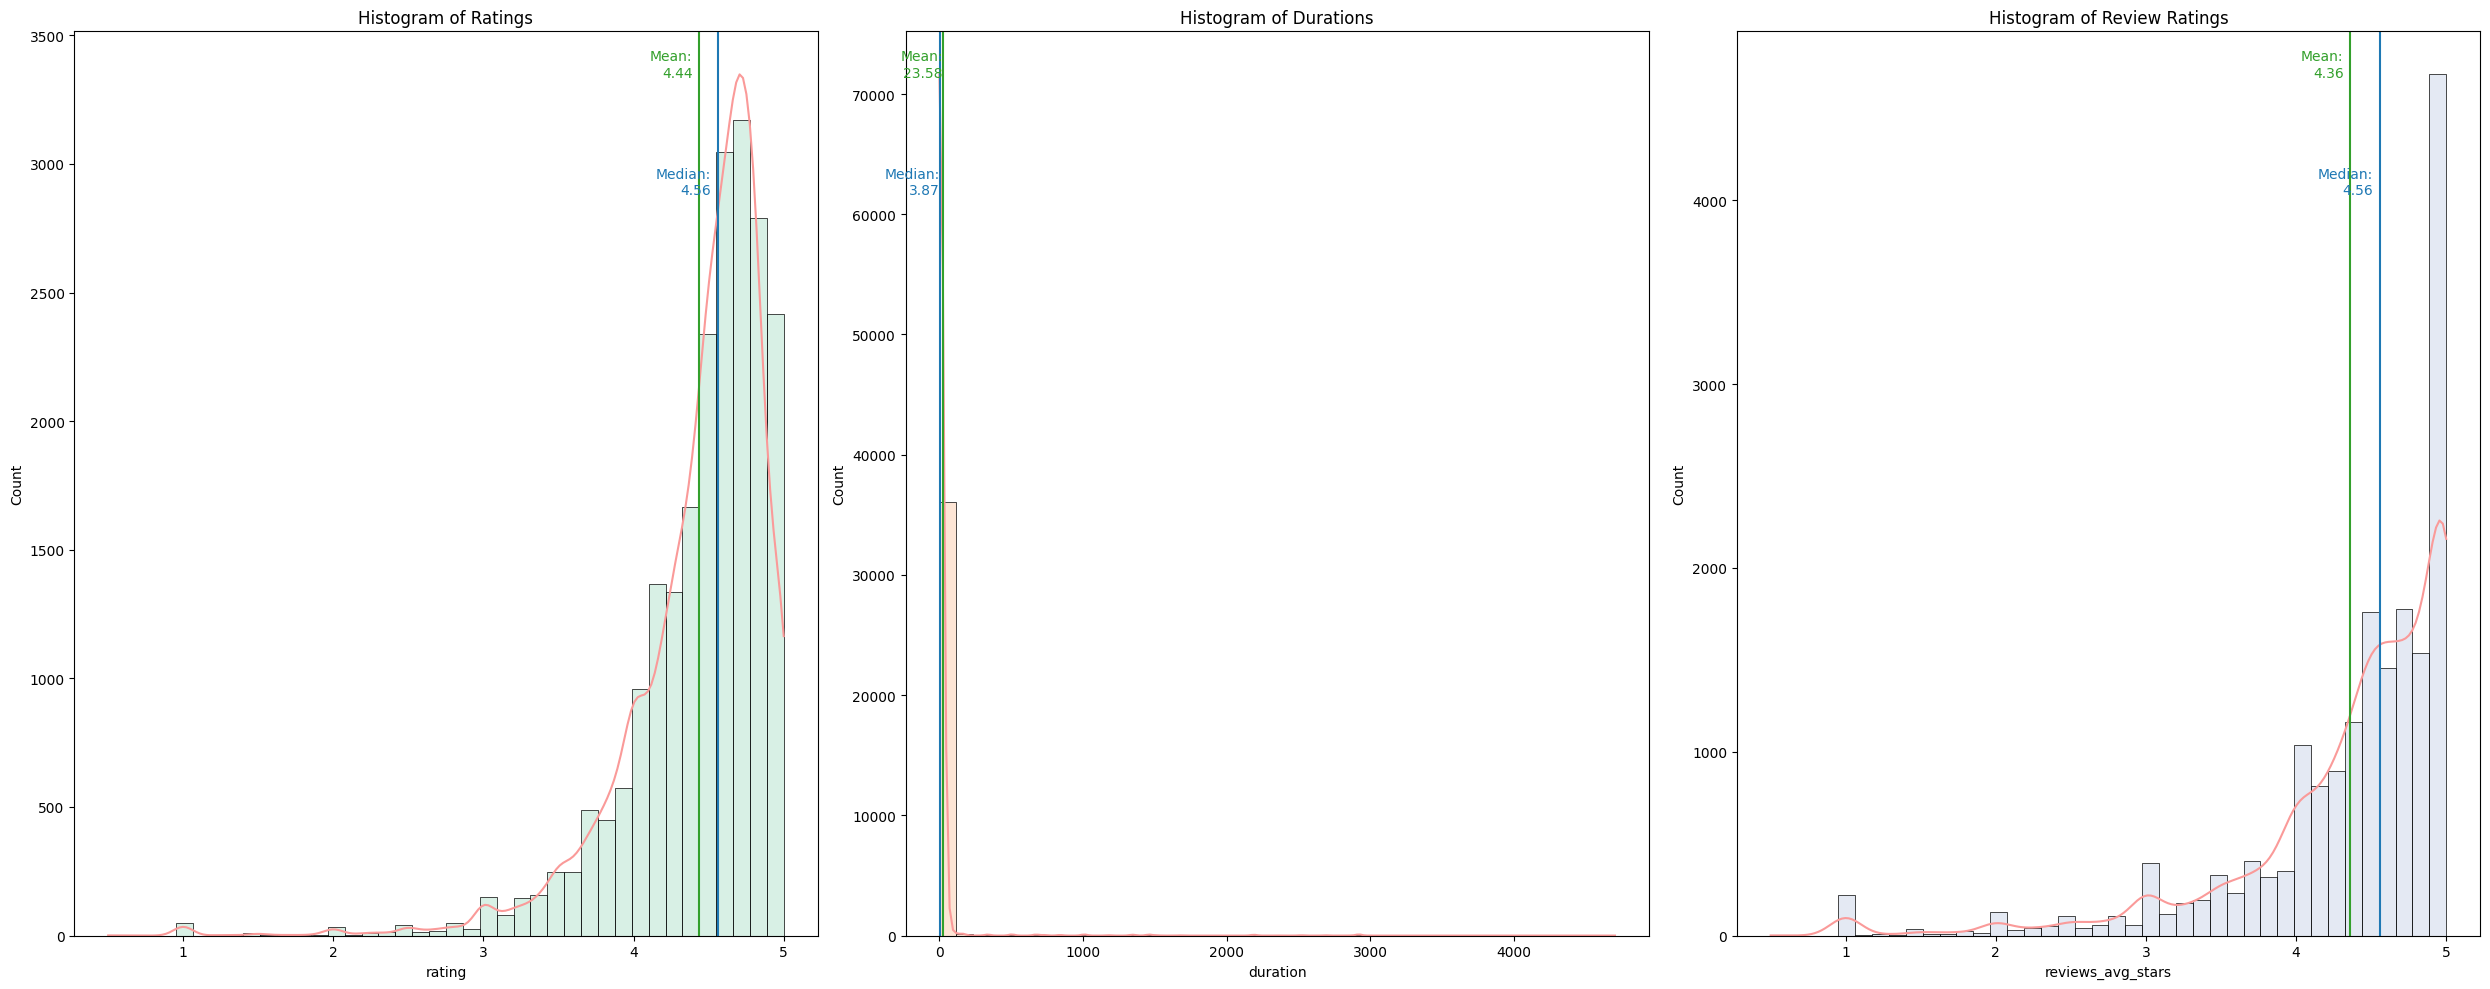

In [8]:
# Density based plots
ratings = df_mooc['rating'].dropna()
duration = df_mooc['duration'].dropna()
reviews_stars = df_mooc['reviews_avg_stars'].dropna()

# Define figure
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)

# Specify plots
custom_hist_kde_plot(ratings, box_color='#b3e2cd', line_color='#fa9a99', title='Histogram of Ratings', axes=ax[0])
custom_hist_kde_plot(duration, box_color='#fdcdac', line_color='#fa9a99', title='Histogram of Durations', axes=ax[1])
custom_hist_kde_plot(reviews_stars, box_color='#cbd5e8', line_color='#fa9a99', title='Histogram of Review Ratings', axes=ax[2])

fig.tight_layout()

Word Clouds - description to be added

NOTE: Every run is different for the wordcloud

In [9]:
# Use only english courses
course_desc = df_mooc[df_mooc['language'] == 'en']
course_desc = course_desc['description'].dropna().reset_index(drop=True)

# Randomly select 50 course descriptions
n = 50
np.random.seed(42)
idx = np.random.choice(range(course_desc.shape[0]), n)
course_desc = course_desc.iloc[idx]

# Merge descriptions into 1 large text
all_desc = ""
for sent in course_desc:
  all_desc += sent

# # Optional: Remove stop words
# word_tokens = word_tokenize(all_desc)
# stop_words = set(stopwords.words('english'))
# filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
# all_desc = " ".join(filtered_sentence)

(-0.5, 399.5, 199.5, -0.5)

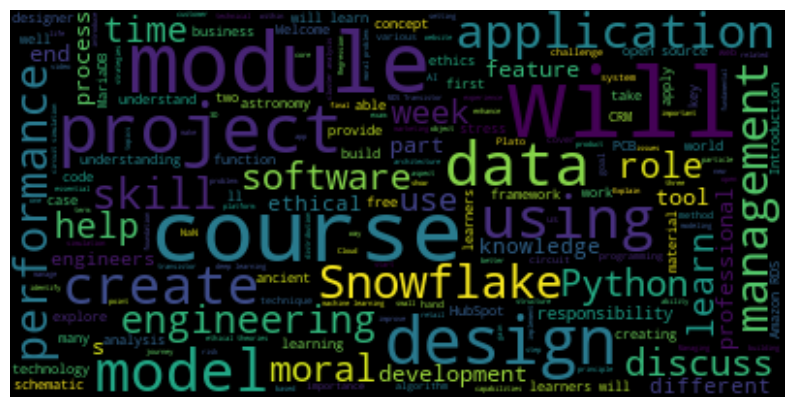

In [10]:
wordcloud = WordCloud(max_font_size=50).generate(all_desc)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [11]:
# For review comments
comments = df_mooc[df_mooc['language'] == 'en']
comments = comments['reviews_comments'].dropna()

# Randomly select 50 sets of comments
n = 50
np.random.seed(42)
idx = np.random.choice(range(comments.shape[0]), n)
comments = comments.iloc[idx]
comments = [i for j in comments.to_numpy() for i in j]

# Merge descriptions into 1 large text
all_desc = ""
for sent in comments:
  all_desc += sent

(-0.5, 399.5, 199.5, -0.5)

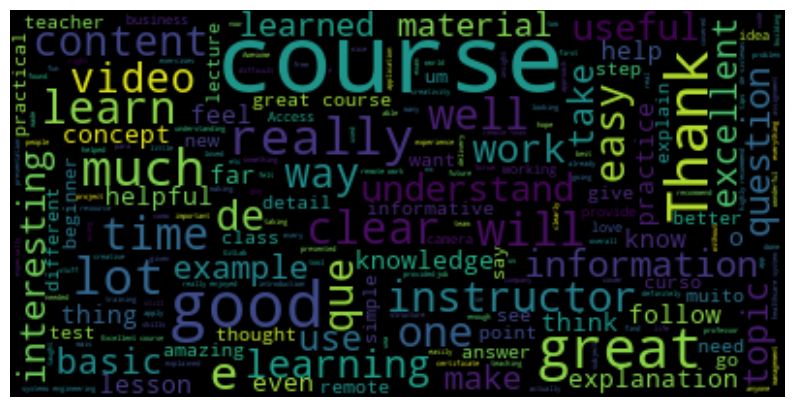

In [12]:
wordcloud = WordCloud(max_font_size=50).generate(all_desc)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

---

# Identify Skill Level in Developers 

Since the Stack Overflow survey has no measure of skill level, we define a reasonable set of rules that assigns a skill level to a developer based on their responses to the survey.

We focus on a few columns and define these rules:
* `CodingStatus` - Their current professional experience as a coder
* `YearsCoding` - Number of years they have spent coding
* `YearsProfessionalCoding` - Number of years they have spent coding professionally

Rules:
1. Respondants who are "Learning to Code are labelled as Beginners
2. Respondants who are "Coding as a hobby" are default Beginners, unless they are above the 75th percentile threshold then they are Intermediate
3. Respondants who are "Former developers" are default Intermediate they generally have much higher years of coding experience compared to other categories. If they are above the 25th percentile, they are Advanced
4. Respondants who are "Not primarily developers" are labelled as Intermediate if they are above the 50th percentile and Advanced if above the 75th percentile. We feel this group will still gain relevant experience which makes them proficient but probably in specialised areas, therefore the threshold to be of higher skill level is higher than those that are primarily developers
5. Respondants who are "Primarily developers" are labelled as Intermediate if they are above the 50th percentile and Advanced if above the 75th percentile.

Additional Notes:
* Many rules are created based on observing the quantile values and histogram distribution conditioned on the `CodingStatus`. Although this values could be considered arbitrary
* Majority of people are categorised as "Intermediate" which is to be expected since it's the default value

In [15]:
so = pd.read_csv("data/clean/survey_results.csv")

In [88]:
# Define rules for level assignment
def index_replace(l: list, ind: list, val: str) -> list:
  l[ind] = val
  return l

def perc(vals: list) -> (float, float, float):
  return np.percentile(vals, 25), np.percentile(vals, 50), np.percentile(vals, 75)

def assign_level(df: pd.DataFrame) -> pd.DataFrame:
  # Default value will be Intermediate
  sl = np.array(["Intermediate" for i in range(df.shape[0])])

  # Coding Status = Learner
  ind = df[df['CodingStatus'] == "I am learning to code"].index 
  sl = index_replace(sl, ind, "Beginner")

  # Coding Status = Hobby
  hobby = df[df['CodingStatus'] == "I code primarily as a hobby"]
  p25, p50, p75 = perc(hobby['YearsCoding'].dropna())
  sl = index_replace(sl, hobby.index, "Beginner") # Default value for this group is Beginner
  ind = hobby[hobby['YearsCoding'] >= p75].index
  sl = index_replace(sl, ind, "Intermediate") 

  # Coding Status = Used to be dev
  olddev = df[df['CodingStatus'] == "I used to be a developer by profession, but no longer am"]
  p25, p50, p75 = perc(olddev['YearsCoding'].dropna())
  sl = index_replace(sl, olddev.index, "Intermediate") # Default value for this group is Intermediate
  ind = olddev[olddev['YearsCoding'] > p25].index
  sl = index_replace(sl, ind, "Advanced") 

  # Coding Status = ptdev
  ptdev = df[df['CodingStatus'] == "I am not primarily a developer, but I write code sometimes as part of my work/studies"]
  p25, p50, p75 = perc(ptdev['YearsCodingProfessional'].dropna())
  sl = index_replace(sl, olddev.index, "Beginner") # Default value for this group is Beginner
  ind = ptdev[( ptdev['YearsCoding'] >= p50 ) & ( ptdev['YearsCoding'] < p75)].index
  sl = index_replace(sl, ind, "Intermediate") 
  ind = ptdev[ptdev['YearsCoding'] > p75].index
  sl = index_replace(sl, ind, "Advanced") 

  # Coding Status = dev
  dev = df[df['CodingStatus'] == "I am a developer by profession"]
  p25, p50, p75 = perc(dev['YearsCodingProfessional'].dropna())
  sl = index_replace(sl, olddev.index, "Beginner") # Default value for this group is Beginner
  ind = dev[( dev['YearsCoding'] >= p25 ) & ( dev['YearsCoding'] < p75)].index
  sl = index_replace(sl, ind, "Intermediate") 
  ind = dev[dev['YearsCoding'] > p75].index
  sl = index_replace(sl, ind, "Advanced") 

  return sl

In [ ]:
# Take a subset of columns to define skill level
sub = so[['CodingStatus', 'AgeRange', 'CodingActivities', 'YearsCoding', 'YearsCodingProfessional', 'YearsWorkExperience']]

# YearsCoding and YearsCodingProfessional have <1 and >50 as values
# Replace these with 0 and 51 respectively to make data numerical for binning
sub.loc[sub['YearsCoding'] == "Less than 1 year", "YearsCoding"] = 0
sub.loc[sub['YearsCoding'] == "More than 50 years", "YearsCoding"] = 50
sub['YearsCoding'] = sub['YearsCoding'].astype(float)
sub.loc[sub['YearsCodingProfessional'] == "Less than 1 year", "YearsCodingProfessional"] = 0
sub.loc[sub['YearsCodingProfessional'] == "More than 50 years", "YearsCodingProfessional"] = 50
sub['YearsCodingProfessional'] = sub['YearsCodingProfessional'].astype(float)

# Assign skill level
skill_level = assign_level(sub)
so['SkillLevel'] = skill_level

C:\Users\User\AppData\Local\Temp\ipykernel_9816\1658121313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['YearsCoding'] = sub['YearsCoding'].astype(float)
C:\Users\User\AppData\Local\Temp\ipykernel_9816\1658121313.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['YearsCodingProfessional'] = sub['YearsCodingProfessional'].astype(float)


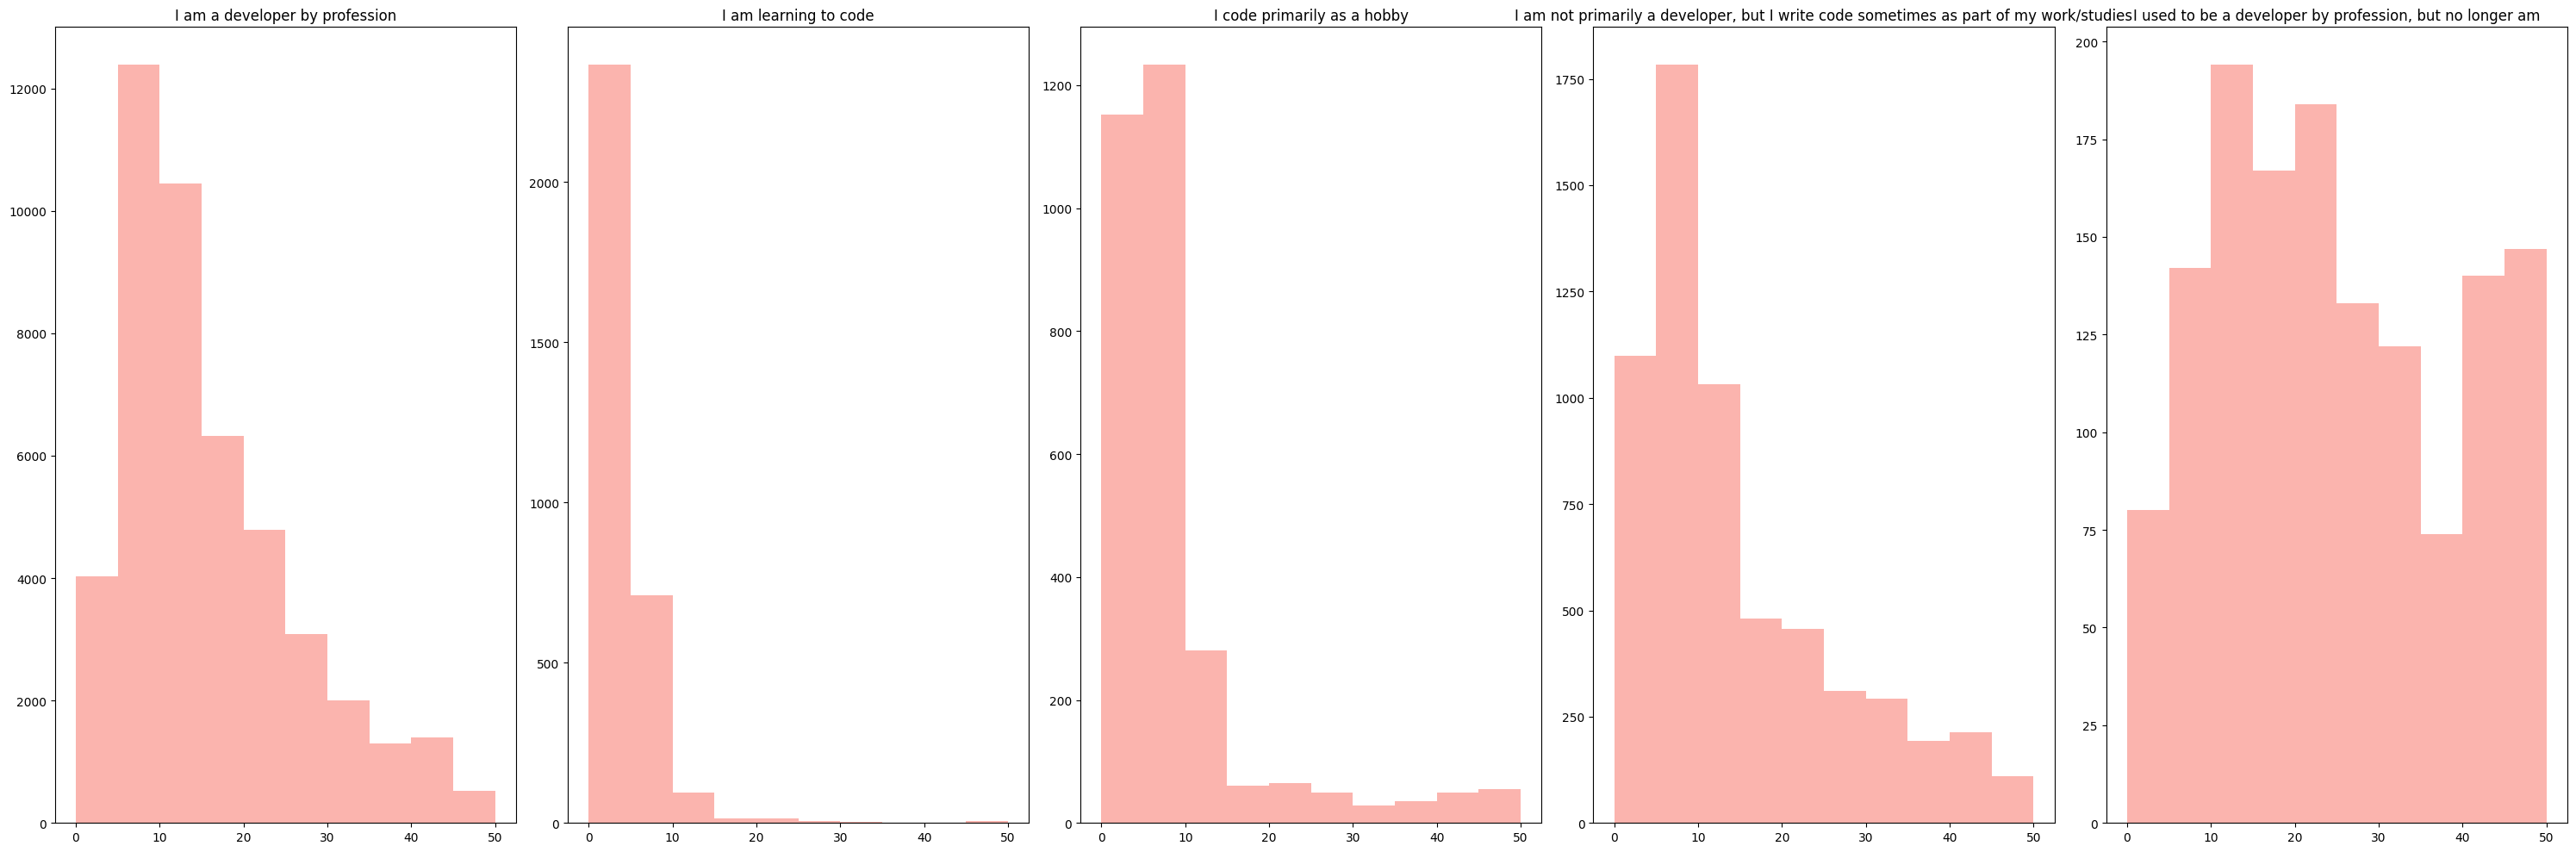

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_figheight(10)
fig.set_figwidth(30)

status = sub['CodingStatus'].unique()
for i in range(len(status)):
  ax[i].hist(sub[sub['CodingStatus'] == status[i]]['YearsCoding'])
  ax[i].set_title(status[i])

fig.tight_layout()

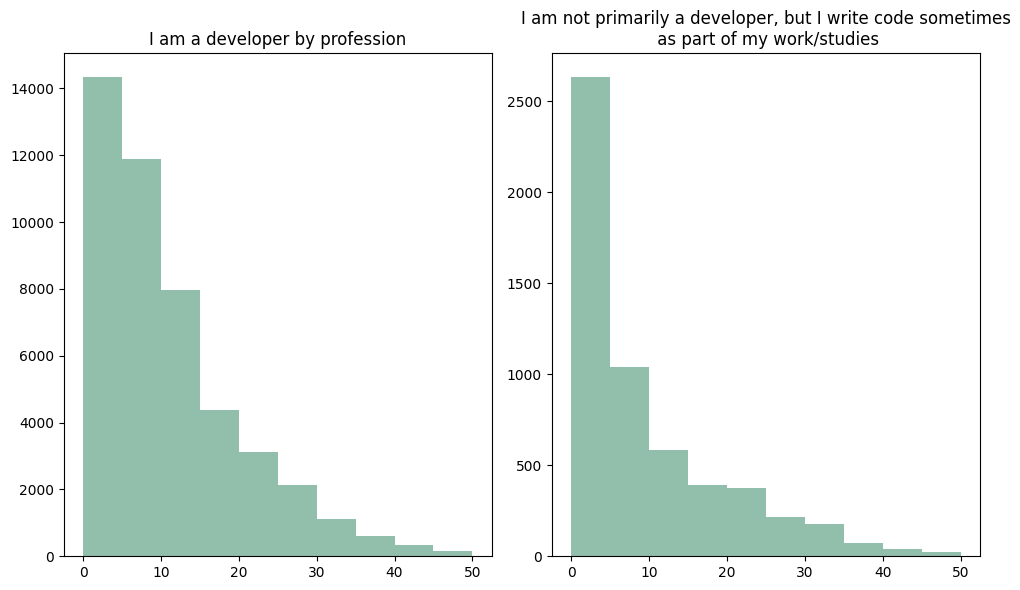

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(10)

status = ['I am a developer by profession', 'I am not primarily a developer, but I write code sometimes\n as part of my work/studies']
for i in range(len(status)):
  ax[i].hist(sub[sub['CodingStatus'] == status[i].replace('\n', '')]['YearsCodingProfessional'], color="#92bfab")
  ax[i].set_title(status[i])

fig.tight_layout()

# Q1: Common Skills

This first question wonders what are the top skills and tools developers of different skill levels are interested in? And do the skills taught by online courses reflect those that developers are interested in?

* Top 5 skills per level
* match skills if they are in the course skills/ description
* Count how many courses are available (maybe percentage)
* Possibly topic modeling?

In [95]:
cols = [
  'SkillLevel',
  'HowLearnCode',
  'HowLearnCodeOnline',
  'LanguagesUsedPastYear',
  'DatabasesUsedPastYear',
  'PlatformsUsedPastYear',
  'WebFramworksUsedPastYear'
]
so_skills = so[cols]

In [111]:
import pyarrow as pa

In [119]:
# Languages
lang = so_skills['WebFramworksUsedPastYear'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)
lang = lang.dropna().astype(pd.ArrowDtype(pa.list_(pa.string())))
lang.list.flatten().unique()

<ArrowExtensionArray>
[       'Express',        'Next.js',        'Node.js',          'React',
   'ASP.NET CORE',         'jQuery',      'WordPress',  'Ruby on Rails',
        'ASP.NET',    'CodeIgniter',         'Blazor',         'Django',
      'AngularJS',        'Angular',          'Flask',         'NestJS',
        'FastAPI',    'Spring Boot',         'Vue.js',        'Fastify',
       'Solid.js',        'Laravel',           'Htmx',           'Deno',
        'Phoenix',          'Remix',         'Svelte',        'Symfony',
 'Play Framework',         'Drupal',            'Elm',         'Gatsby',
        'Nuxt.js',         'Strapi',          'Yii 2',          'Astro']
Length: 36, dtype: string[pyarrow]

In [96]:
so_skills.head()

,SkillLevel,HowLearnCode,HowLearnCodeOnline,LanguagesUsedPastYear,DatabasesUsedPastYear,PlatformsUsedPastYear,WebFramworksUsedPastYear
0,Intermediate,['Books / Physical media'],NaN,NaN,NaN,NaN,NaN
1,Advanced,"['Books / Physical media', 'Colleague', 'On th...","['Technical documentation', 'Blogs', 'Books', ...","['Bash/Shell (all shells)', 'Go', 'HTML/CSS', ...","['Dynamodb', 'MongoDB', 'PostgreSQL']","['Amazon Web Services (AWS)', 'Heroku', 'Netli...","['Express', 'Next.js', 'Node.js', 'React']"
2,Advanced,"['Books / Physical media', 'Colleague', 'On th...","['Technical documentation', 'Blogs', 'Books', ...",['C#'],['Firebase Realtime Database'],['Google Cloud'],['ASP.NET CORE']
3,Beginner,"['Other online resources (e.g., videos, blogs,...","['Stack Overflow', 'How-to videos', 'Interacti...","['C', 'C++', 'HTML/CSS', 'Java', 'JavaScript',...","['MongoDB', 'MySQL', 'PostgreSQL', 'SQLite']","['Amazon Web Services (AWS)', 'Fly.io', 'Heroku']","['jQuery', 'Next.js', 'Node.js', 'React', 'Wor..."
4,Intermediate,"['Other online resources (e.g., videos, blogs,...","['Technical documentation', 'Blogs', 'Written ...","['C++', 'HTML/CSS', 'JavaScript', 'Lua', 'Pyth...","['PostgreSQL', 'SQLite']",NaN,NaN


In [121]:
df_mooc['skills'].dropna().shape

(24887,)

# Q2: Medium and Duration

The next questions tries to identify whether certain skills that might be considered advanced by developers take a longer time to develop i.e what skills as suggested by online courses might take the longest to teach?